
Running S1: Stationary demand: T_eval=50000, trials=8

Running S2: Demand with shocks: T_eval=50000, trials=8

Running S3: Drifting demand: T_eval=50000, trials=8

Running S4: Misspecified demand model: T_eval=50000, trials=8


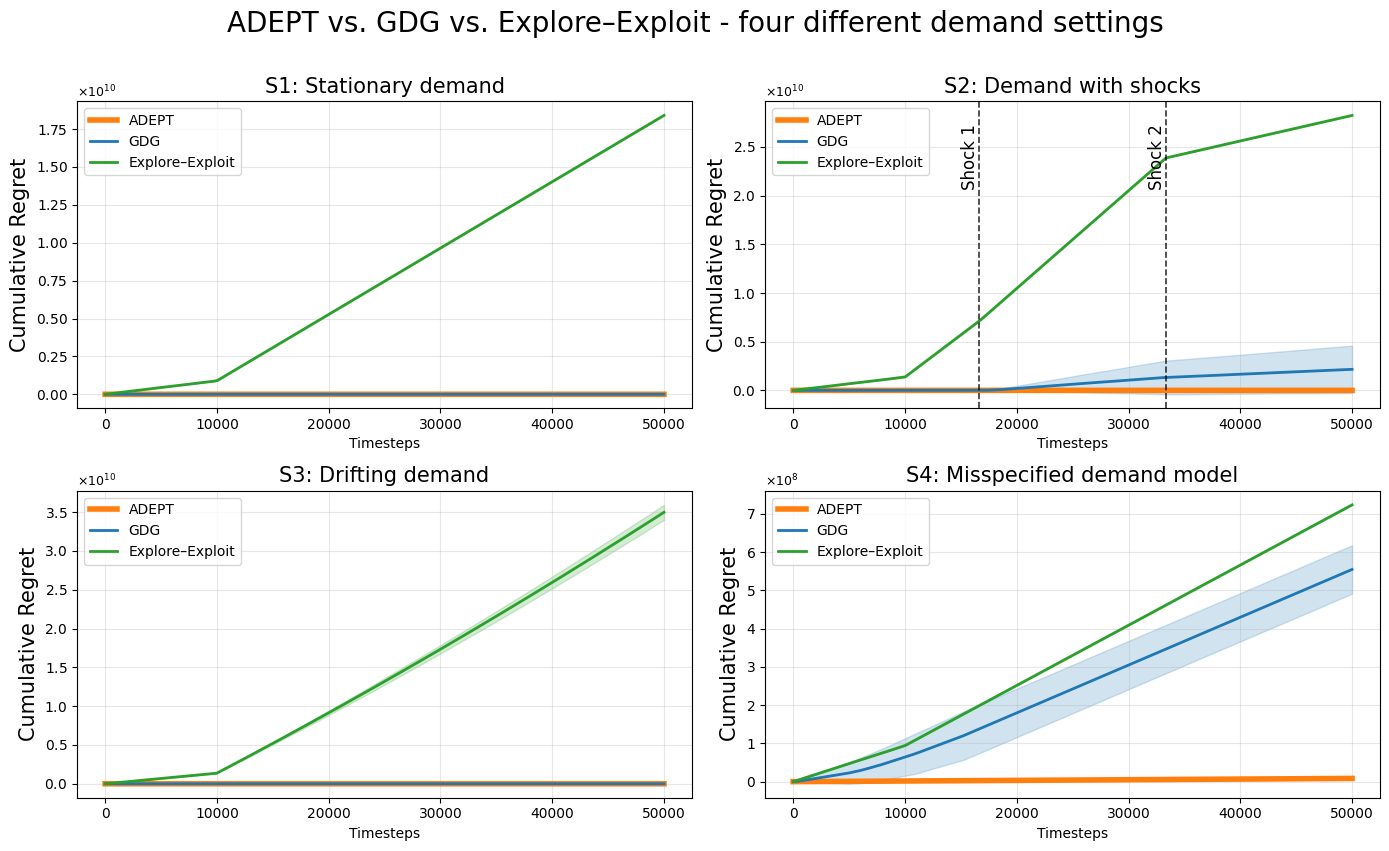

In [1]:
# ============================================================
# Revised ADEPT (2-pt, preconditioned in original space) vs
# GDG (1-pt, orthonormal span) vs Explore–Exploit (1-pt)
#
# Fair protocol: matched evaluation budget T_eval for all methods.
# ADEPT uses two evals per update (p+, p-); regret counted at each eval.
# Four demand settings: Stationary, Shocks, Drifting, Misspecified
# Price constraint: same L2-ball for all; regret vs best fixed price in that ball.
# T_eval = 50_000; 8 trials; y-axis scientific; shock markers.
# ============================================================

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# ----------------------- Global CONFIG -----------------------
N, d = 60, 6                  # products, latent dimension
T_eval = 50_000               # total evaluations (function calls)
TRIALS = 8
NOISE_SD = 0.5
R_P_SCALE = 8.0               # price-ball radius = R_P_SCALE * sqrt(d)
MASTER_SEED = 123
EE_EXPLORE_FRAC = 0.20
RIDGE_L2 = 1e-2

# ----------------------- Utilities ---------------------------
def proj_ball(v, R):
    n = la.norm(v)
    return v if (n <= R or n == 0.0) else (v * (R/n))

def best_price_in_ball(H, Hz, R, tol=1e-8, maxit=100):
    """ max_p -p^T H p + p^T Hz  s.t. ||p||<=R (trust region). """
    eps = 1e-8
    p_free = la.solve(2*H + eps*np.eye(H.shape[0]), Hz)
    if la.norm(p_free) <= R:
        return p_free
    lam_lo, lam_hi = 0.0, 1.0
    for _ in range(60):  # bracket λ
        p = la.solve(2*H + lam_hi*np.eye(H.shape[0]), Hz)
        if la.norm(p) <= R: break
        lam_hi *= 2.0
    for _ in range(maxit):  # bisection
        lam = 0.5*(lam_lo + lam_hi)
        p = la.solve(2*H + lam*np.eye(H.shape[0]), Hz)
        nrm = la.norm(p)
        if abs(nrm - R) <= tol: return proj_ball(p, R)
        if nrm > R: lam_lo = lam
        else:       lam_hi = lam
    return proj_ball(p, R)

def non_orthonormal_U(N, d, rng):
    U_raw = rng.normal(size=(N, d))
    C = 0.6*np.ones((d, d)) + 0.4*np.eye(d)  # correlated columns
    return U_raw @ la.cholesky(C)

# G-geometry helpers
def G_norm(G, v):
    return float(np.sqrt(v.T @ G @ v + 1e-12))

def project_to_G_ball(G, v, R):
    nG = G_norm(G, v)
    if nG <= R or nG == 0.0: return v
    return v * (R / nG)

# ----------------------- Algorithms --------------------------
def ADEPT_two_point_precond_eval(T_eval, U, R_p, true_rev_t, noisy_rev_t, p_star,
                                 norm_eff, restart_points=None, seed=0):
    """
    Revised ADEPT:
      - Parameter φ in R^d; price p = U φ
      - G = U^T U; use mirror/preconditioned step: φ <- φ - η * G^{-1} g
      - Two-point estimator at each update: play p+ and p- on consecutive evals
      - Feasibility: keep φ in G-ball (||Uφ||<=R_p); choose δ_eff so p± stay feasible
      - Step/δ scaled by norm_eff ≈ ||G^{1/2} V G^{1/2}||_2 (or conservative fallback)
      - Optional restarts at provided evaluation indices
    """
    rng = np.random.default_rng(seed)
    d = U.shape[1]
    G = U.T @ U
    # Precompute G^{-1} (small d)
    Ginv = la.inv(G + 1e-12*np.eye(d))

    # curvature-aware schedules (T_eval for eval steps)
    eta   = (0.9 / (1.0 + norm_eff)) / (T_eval**0.5)
    delta = (1.0 / np.sqrt(1.0 + norm_eff)) / (T_eval**0.25)

    phi = np.zeros(d)
    reg_hist = np.empty(T_eval, dtype=float)
    cum_reg = 0.0

    # for two-point pairing
    have_half = False
    u = None; r_plus = None; delta_eff = None

    restart_set = set(restart_points or [])

    for t in range(T_eval):
        # Restart at designated eval steps (useful for shocks; mild periodic under drift)
        if t in restart_set:
            phi[:] = 0.0
            have_half = False  # reset pairing

        if not have_half:
            # Sample direction in G-geometry: normalize so ||U u|| = 1
            u = rng.normal(size=d)
            # normalize in G-norm
            un = G_norm(G, u)
            if un < 1e-12:
                u = np.ones(d); un = G_norm(G, u)
            u = u / un

            # Choose δ_eff so p+ stays in ball without projection
            rad = G_norm(G, phi)  # = ||U phi||
            delta_eff = max(1e-12, min(delta, R_p - rad))
            # If we are already on boundary, shrink a bit
            if delta_eff <= 1e-12:
                # tiny inward nudge (mirror shrink)
                phi = project_to_G_ball(G, 0.99*phi, R_p)
                delta_eff = 1e-3 * R_p

            p_plus = U @ (phi + delta_eff*u)
            r_plus = noisy_rev_t(p_plus, t)

            # regret at this evaluation
            cum_reg += true_rev_t(p_star, t) - true_rev_t(p_plus, t)
            reg_hist[t] = cum_reg
            have_half = True
        else:
            # Play the antithetic arm
            p_minus = U @ (phi - delta_eff*u)
            r_minus = noisy_rev_t(p_minus, t)

            # two-point gradient on f = -R wrt φ
            g = - (r_plus - r_minus) * u / (2.0 * delta_eff)
            # mirror/preconditioned step
            phi = phi - eta * (Ginv @ g)
            # keep φ inside G-ball
            phi = project_to_G_ball(G, phi, R_p)

            # regret at this evaluation
            cum_reg += true_rev_t(p_star, t) - true_rev_t(p_minus, t)
            reg_hist[t] = cum_reg
            have_half = False

    return reg_hist

def GDG_one_point_eval(T_eval, O, R_p, true_rev_t, noisy_rev_t, p_star, normV, seed=0):
    """ 1-point GD in orthonormal x-space; one evaluation per step. """
    rng = np.random.default_rng(seed)
    d = O.shape[1]
    eta   = (0.9 / (1.0 + normV)) / (T_eval**0.5)
    delta = (1.0 / np.sqrt(1.0 + normV)) / (T_eval**0.25)

    x = np.zeros(d)
    reg_hist = np.empty(T_eval, dtype=float)
    cum_reg = 0.0

    for t in range(T_eval):
        u = rng.normal(size=d); u /= la.norm(u) + 1e-12
        x_tilde = x + delta*u
        p_t = proj_ball(O @ x_tilde, R_p)
        r_t = noisy_rev_t(p_t, t)
        g = -(r_t) * u / delta
        x = x - eta*g
        # keep x feasible (||Ox||=||x||)
        nx = la.norm(x)
        if nx > R_p: x *= (R_p/nx)

        cum_reg += true_rev_t(p_star, t) - true_rev_t(p_t, t)
        reg_hist[t] = cum_reg

    return reg_hist

def EE_one_point_eval(T_eval, O, R_p, true_rev_t, noisy_rev_t, p_star,
                      normV, seed=0, explore_frac=EE_EXPLORE_FRAC, ridge_l2=RIDGE_L2):
    """ Two-phase Explore–Exploit in x-space with one evaluation per step. """
    rng = np.random.default_rng(seed)
    d = O.shape[1]
    T0 = max(10*d*(d+1), int(explore_frac * T_eval))
    T0 = min(T0, T_eval-1)

    def quad_feats(x):
        idx = np.triu_indices(d)
        xx = np.outer(x, x)[idx]
        return np.concatenate([xx, x])

    X, y = [], []
    reg_hist = np.empty(T_eval, dtype=float)
    cum_reg = 0.0

    # Exploration
    for t in range(T0):
        u = rng.normal(size=d); u /= la.norm(u) + 1e-12
        r = R_p * (rng.random() ** (1.0/d))
        x = r * u
        p = proj_ball(O @ x, R_p)
        r_obs = noisy_rev_t(p, t)
        X.append(quad_feats(x)); y.append(r_obs)
        cum_reg += true_rev_t(p_star, t) - true_rev_t(p, t)
        reg_hist[t] = cum_reg

    # Fit quadratic surrogate (ridge)
    X = np.vstack(X); y = np.asarray(y)
    m = X.shape[1]
    XtX = X.T @ X
    XtX.flat[::m+1] += ridge_l2
    theta = la.solve(XtX, X.T @ y)

    m_q = d*(d+1)//2
    a_flat = theta[:m_q]; b_hat = -theta[m_q:]
    A_hat = np.zeros((d, d)); idx = np.triu_indices(d)
    A_hat[idx] = a_flat; A_hat = A_hat + A_hat.T - np.diag(np.diag(A_hat))
    # PSD stabilization
    w, V = la.eigh(A_hat); A_hat = (V * np.clip(w, 1e-6, None)) @ V.T

    # Trust-region in x-space: maximize -x^T A_hat x + x^T b_hat s.t. ||x||<=R_p
    def trust_region_x(A, b, R):
        return best_price_in_ball(A, b, R)

    x_star = trust_region_x(A_hat, b_hat, R_p)
    p_exploit = O @ x_star

    for t in range(T0, T_eval):
        p = proj_ball(p_exploit, R_p)
        cum_reg += true_rev_t(p_star, t) - true_rev_t(p, t)
        reg_hist[t] = cum_reg

    return reg_hist

# ----------------------- Demand settings ---------------------
def build_stationary(N, d, T_eval, noise_sd, seed):
    rng = np.random.default_rng(seed + 1101)
    U = non_orthonormal_U(N, d, rng)
    A = rng.normal(size=(d, d))
    V = A @ A.T + 0.5*np.eye(d)
    z = rng.normal(loc=3.0, scale=1.0, size=d)

    Hz = U @ z
    H  = U @ V @ U.T

    Hsum  = T_eval * H
    Hzsum = T_eval * Hz

    R_p = R_P_SCALE * np.sqrt(d)

    def true_rev_t(p, t): return p @ Hz - p @ (H @ p)
    def noisy_rev_t(p, t): return true_rev_t(p, t) + rng.normal(0.0, noise_sd)

    O, P = la.qr(U, mode='reduced')
    # curvature scalers
    G = U.T @ U
    # ||G^{1/2} V G^{1/2}||_2 == ||P V P^T||_2 (same as below), but compute in ADEPT form:
    w_eff = la.norm(la.multi_dot([la.cholesky(G), V, la.cholesky(G).T]), 2)
    norm_ADEPT = w_eff
    norm_GDG   = la.norm(P @ V @ P.T, 2)

    # Restart points: none for stationary
    restarts = []

    p_star = best_price_in_ball(Hsum + 1e-8*np.eye(N), Hzsum, R_p)
    return U, O, R_p, p_star, true_rev_t, noisy_rev_t, norm_ADEPT, norm_GDG, restarts, {"shocks": None}

def build_shocks(N, d, T_eval, noise_sd, seed):
    rng = np.random.default_rng(seed + 1202)
    U = non_orthonormal_U(N, d, rng)
    cut1, cut2 = T_eval//3, 2*T_eval//3

    z_list, V_list = [], []
    for _ in range(3):
        z_b = rng.normal(loc=3.0, scale=1.0, size=d)
        A_b = rng.normal(size=(d, d)); V_b = A_b @ A_b.T + 0.5*np.eye(d)
        z_list.append(z_b); V_list.append(V_b)

    Hz_t = np.zeros((T_eval, N))
    H_t  = np.zeros((T_eval, N, N))
    for t in range(T_eval):
        b = 0 if t < cut1 else (1 if t < cut2 else 2)
        z, V = z_list[b], V_list[b]
        Hz_t[t] = U @ z
        H_t[t]  = U @ V @ U.T

    Hsum  = H_t.sum(axis=0)
    Hzsum = Hz_t.sum(axis=0)
    R_p = R_P_SCALE * np.sqrt(d)

    def true_rev_t(p, t): return p @ Hz_t[t] - p @ (H_t[t] @ p)
    def noisy_rev_t(p, t): return true_rev_t(p, t) + rng.normal(0.0, noise_sd)

    O, P = la.qr(U, mode='reduced')
    V_bar = sum(V_list)/3.0
    G = U.T @ U
    w_eff = la.norm(la.multi_dot([la.cholesky(G), V_bar, la.cholesky(G).T]), 2)
    norm_ADEPT = w_eff
    norm_GDG   = la.norm(P @ V_bar @ P.T, 2)

    # Restarts at shocks (evaluation indices)
    restarts = [cut1, cut2]

    p_star = best_price_in_ball(Hsum + 1e-8*np.eye(N), Hzsum, R_p)
    return U, O, R_p, p_star, true_rev_t, noisy_rev_t, norm_ADEPT, norm_GDG, restarts, {"shocks": [cut1, cut2]}

def build_drifting(N, d, T_eval, noise_sd, seed):
    rng = np.random.default_rng(seed + 1303)
    U = non_orthonormal_U(N, d, rng)

    z0 = rng.normal(loc=2.5, scale=1.0, size=d)
    z1 = rng.normal(loc=3.5, scale=1.0, size=d)
    A0 = rng.normal(size=(d, d)); V0 = A0 @ A0.T + 0.5*np.eye(d)
    A1 = rng.normal(size=(d, d)); V1 = A1 @ A1.T + 0.5*np.eye(d)

    lin = np.linspace(0.0, 1.0, T_eval)
    z_t = (1.0 - lin)[:, None] * z0 + lin[:, None] * z1

    Hz_t = (U @ z_t.T).T
    H_t  = np.zeros((T_eval, N, N))
    for i, w in enumerate(lin):
        V = (1.0 - w) * V0 + w * V1
        H_t[i] = U @ V @ U.T

    Hsum  = H_t.sum(axis=0)
    Hzsum = Hz_t.sum(axis=0)
    R_p = R_P_SCALE * np.sqrt(d)

    def true_rev_t(p, t): return p @ Hz_t[t] - p @ (H_t[t] @ p)
    def noisy_rev_t(p, t): return true_rev_t(p, t) + rng.normal(0.0, noise_sd)

    O, P = la.qr(U, mode='reduced')
    V_bar = 0.5*(V0 + V1)
    G = U.T @ U
    w_eff = la.norm(la.multi_dot([la.cholesky(G), V_bar, la.cholesky(G).T]), 2)
    norm_ADEPT = w_eff
    norm_GDG   = la.norm(P @ V_bar @ P.T, 2)

    # Mild periodic restarts (help on slow drift)
    restarts = [T_eval//4, T_eval//2, 3*T_eval//4]

    p_star = best_price_in_ball(Hsum + 1e-8*np.eye(N), Hzsum, R_p)
    return U, O, R_p, p_star, true_rev_t, noisy_rev_t, norm_ADEPT, norm_GDG, restarts, {"shocks": None}

def build_misspecified(N, d, T_eval, noise_sd, seed):
    rng = np.random.default_rng(seed + 1404)
    U = non_orthonormal_U(N, d, rng)

    # True full-rank quadratic in price space (algorithms act in low-rank span / G-geometry)
    W = rng.normal(size=(N, max(d+5, N//2)))
    G_full = W @ W.T + 0.5*np.eye(N)
    b_full = rng.normal(loc=3.0, scale=1.0, size=N)

    H = G_full
    Hz = b_full
    Hsum  = T_eval * H
    Hzsum = T_eval * Hz

    R_p = R_P_SCALE * np.sqrt(d)

    def true_rev_t(p, t): return p @ b_full - p @ (G_full @ p)
    def noisy_rev_t(p, t): return true_rev_t(p, t) + rng.normal(0.0, noise_sd)

    O, _ = la.qr(U, mode='reduced')
    # Conservative curvature scalers (V unknown/misspecified)
    norm_ADEPT = 1.0
    norm_GDG   = 1.0

    restarts = []

    p_star = best_price_in_ball(Hsum + 1e-8*np.eye(N), Hzsum, R_p)
    return U, O, R_p, p_star, true_rev_t, noisy_rev_t, norm_ADEPT, norm_GDG, restarts, {"shocks": None}

# ----------------------- Runner & Plotting -------------------
def run_setting(builder_fn, title):
    print(f"\nRunning {title}: T_eval={T_eval}, trials={TRIALS}")
    (U, O, R_p, p_star, true_rev_t, noisy_rev_t,
     norm_ADEPT, norm_GDG, restarts, meta) = builder_fn(N, d, T_eval, NOISE_SD, MASTER_SEED)

    regs_adept = np.empty((TRIALS, T_eval))
    regs_gdg   = np.empty((TRIALS, T_eval))
    regs_ee    = np.empty((TRIALS, T_eval))

    for k in range(TRIALS):
        regs_adept[k] = ADEPT_two_point_precond_eval(
            T_eval, U, R_p, true_rev_t, noisy_rev_t, p_star, norm_ADEPT,
            restart_points=restarts, seed=MASTER_SEED + 2000 + 17*k
        )
        regs_gdg[k] = GDG_one_point_eval(
            T_eval, O, R_p, true_rev_t, noisy_rev_t, p_star, norm_GDG,
            seed=MASTER_SEED + 3000 + 19*k
        )
        regs_ee[k] = EE_one_point_eval(
            T_eval, O, R_p, true_rev_t, noisy_rev_t, p_star, norm_GDG,
            seed=MASTER_SEED + 4000 + 23*k
        )

    return regs_adept, regs_gdg, regs_ee, meta

def main():
    settings = [
        ("S1: Stationary demand",            build_stationary),
        ("S2: Demand with shocks",           build_shocks),
        ("S3: Drifting demand",              build_drifting),
        ("S4: Misspecified demand model",    build_misspecified),
    ]

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    axes = axes.flatten()

    for i, (title, builder) in enumerate(settings):
        regs_a, regs_g, regs_e, meta = run_setting(builder, title)

        mean_a, std_a = regs_a.mean(axis=0), regs_a.std(axis=0)
        mean_g, std_g = regs_g.mean(axis=0), regs_g.std(axis=0)
        mean_e, std_e = regs_e.mean(axis=0), regs_e.std(axis=0)

        x = np.arange(T_eval)
        ax = axes[i]

        ax.plot(x, mean_a, lw=4, color="C1", label="ADEPT")
        ax.fill_between(x, mean_a - std_a, mean_a + std_a, alpha=0.80, color="C1")

        ax.plot(x, mean_g, lw=2, color="C0", label="GDG")
        ax.fill_between(x, mean_g - std_g, mean_g + std_g, alpha=0.20, color="C0")

        ax.plot(x, mean_e, lw=2, color="C2", label="Explore–Exploit")
        ax.fill_between(x, mean_e - std_e, mean_e + std_e, alpha=0.20, color="C2")

        # Shock markers
        if meta.get("shocks") is not None:
            for pos in meta["shocks"]:
                ax.axvline(pos, color="k", linestyle="--", linewidth=1.2, alpha=0.8)
            ytop = ax.get_ylim()[1]
            if len(meta["shocks"]) >= 1:
                ax.text(meta["shocks"][0], ytop*0.92, "Shock 1", rotation=90, va="top", ha="right", fontsize=12)
            if len(meta["shocks"]) >= 2:
                ax.text(meta["shocks"][1], ytop*0.92, "Shock 2", rotation=90, va="top", ha="right", fontsize=12)

        ax.set_title(title,fontsize=15)
        ax.set_xlabel("Timesteps",fontsize=10)
        ax.set_ylabel("Cumulative Regret",fontsize=15)
        ax.grid(alpha=0.3)
        ax.legend(loc="upper left")

        # Force sci notation
        fmt = ScalarFormatter(useMathText=True)
        fmt.set_scientific(True); fmt.set_powerlimits((0, 0)); fmt.set_useMathText(True)
        ax.yaxis.set_major_formatter(fmt)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
        ax.yaxis.get_offset_text().set_fontsize(9)

    fig.suptitle("ADEPT vs. GDG vs. Explore–Exploit - four different demand settings",
                 fontsize=20)
    fig.tight_layout(rect=[0, 0.04, 1, 0.97])
    plt.show()

if __name__ == "__main__":
    main()
